Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

In [3]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [4]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [5]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [5]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [6]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 4.913177
Minibatch accuracy: 0.0%
Validation accuracy: 10.0%
Minibatch loss at step 50: 1.104410
Minibatch accuracy: 75.0%
Validation accuracy: 58.5%
Minibatch loss at step 100: 1.266695
Minibatch accuracy: 75.0%
Validation accuracy: 75.8%
Minibatch loss at step 150: 1.200520
Minibatch accuracy: 81.2%
Validation accuracy: 73.5%
Minibatch loss at step 200: 1.018956
Minibatch accuracy: 68.8%
Validation accuracy: 76.2%
Minibatch loss at step 250: 0.367287
Minibatch accuracy: 93.8%
Validation accuracy: 79.3%
Minibatch loss at step 300: 1.021968
Minibatch accuracy: 75.0%
Validation accuracy: 80.1%
Minibatch loss at step 350: 0.467771
Minibatch accuracy: 87.5%
Validation accuracy: 81.2%
Minibatch loss at step 400: 0.106202
Minibatch accuracy: 100.0%
Validation accuracy: 81.3%
Minibatch loss at step 450: 0.634112
Minibatch accuracy: 68.8%
Validation accuracy: 82.2%
Minibatch loss at step 500: 0.741699
Minibatch accuracy: 68.8%
Validation accuracy: 81.8%
M

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

Initialized
Minibatch loss at step 0: 4.700264
Minibatch accuracy: 17.2%
Validation accuracy: 10.0%
Minibatch loss at step 500: 0.731014
Minibatch accuracy: 82.8%
Validation accuracy: 82.6%
Minibatch loss at step 1000: 0.703233
Minibatch accuracy: 81.2%
Validation accuracy: 85.7%
Minibatch loss at step 1500: 0.544789
Minibatch accuracy: 85.9%
Validation accuracy: 86.4%
Minibatch loss at step 2000: 0.338990
Minibatch accuracy: 85.9%
Validation accuracy: 86.9%
Minibatch loss at step 2500: 0.413246
Minibatch accuracy: 89.1%
Validation accuracy: 87.7%
Minibatch loss at step 3000: 0.503424
Minibatch accuracy: 87.5%
Validation accuracy: 87.7%
Minibatch loss at step 3500: 0.576128
Minibatch accuracy: 81.2%
Validation accuracy: 88.2%
Minibatch loss at step 4000: 0.431490
Minibatch accuracy: 89.1%
Validation accuracy: 88.6%
Minibatch loss at step 4500: 0.797310
Minibatch accuracy: 78.1%
Validation accuracy: 88.8%
Minibatch loss at step 5000: 0.544933
Minibatch accuracy: 79.7%
Validation accurac

Validation accuracy: 91.4%
Minibatch loss at step 45000: 0.213568
Minibatch accuracy: 95.3%
Validation accuracy: 91.5%
Minibatch loss at step 45500: 0.328850
Minibatch accuracy: 92.2%
Validation accuracy: 91.5%
Minibatch loss at step 46000: 0.317242
Minibatch accuracy: 89.1%
Validation accuracy: 91.4%
Minibatch loss at step 46500: 0.444307
Minibatch accuracy: 85.9%
Validation accuracy: 91.6%
Minibatch loss at step 47000: 0.553545
Minibatch accuracy: 84.4%
Validation accuracy: 91.5%
Minibatch loss at step 47500: 0.409577
Minibatch accuracy: 92.2%
Validation accuracy: 91.5%
Minibatch loss at step 48000: 0.309722
Minibatch accuracy: 92.2%
Validation accuracy: 91.6%
Minibatch loss at step 48500: 0.367176
Minibatch accuracy: 87.5%
Validation accuracy: 91.5%
Minibatch loss at step 49000: 0.744951
Minibatch accuracy: 79.7%
Validation accuracy: 91.6%
Minibatch loss at step 49500: 0.355329
Minibatch accuracy: 90.6%
Validation accuracy: 91.5%
Minibatch loss at step 50000: 0.394264
Minibatch accu

Minibatch loss at step 89500: 0.566146
Minibatch accuracy: 85.9%
Validation accuracy: 92.0%
Minibatch loss at step 90000: 0.491114
Minibatch accuracy: 84.4%
Validation accuracy: 92.1%
Minibatch loss at step 90500: 0.186469
Minibatch accuracy: 95.3%
Validation accuracy: 92.0%
Minibatch loss at step 91000: 0.610046
Minibatch accuracy: 78.1%
Validation accuracy: 92.1%
Minibatch loss at step 91500: 0.333986
Minibatch accuracy: 89.1%
Validation accuracy: 91.9%
Minibatch loss at step 92000: 0.297454
Minibatch accuracy: 93.8%
Validation accuracy: 91.9%
Minibatch loss at step 92500: 0.319086
Minibatch accuracy: 90.6%
Validation accuracy: 91.9%
Minibatch loss at step 93000: 0.395375
Minibatch accuracy: 84.4%
Validation accuracy: 92.1%
Minibatch loss at step 93500: 0.519242
Minibatch accuracy: 82.8%
Validation accuracy: 92.0%
Minibatch loss at step 94000: 0.591796
Minibatch accuracy: 81.2%
Validation accuracy: 92.0%
Minibatch loss at step 94500: 0.361407
Minibatch accuracy: 90.6%
Validation accu

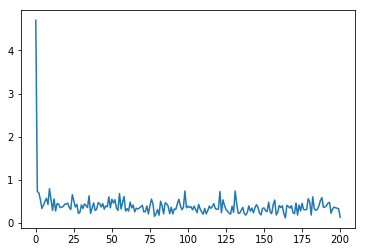

In [30]:
batch_size = 64     # 128
num_hidden = 64
num_steps = 100001
decay_rate = 0.98               # 0.96
initial_learning_rate = 0.1     # 0.5

# Regularization
keep_prob = 0.5                 # dropout
weights_penalty=0.0001          # 0.001

# Convolutional hyperparameters
patch_size = 5       # 5
padding = 'SAME'
depth = 16           # 32

import time
import matplotlib.pyplot as plt
t = time.time()
loss_series = []

graph = tf.Graph()
with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.zeros([depth]))

    #layer3_weights = tf.Variable(tf.truncated_normal(
    #        [(image_size - 3*patch_size + 3) // 4 * (image_size - 3*patch_size + 3) // 4 * depth, num_hidden], stddev=0.1))
    layer3_weights = tf.Variable(tf.truncated_normal(
            [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.zeros([num_hidden]))
    
    layer4_weights = tf.Variable(tf.truncated_normal(
            [num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

    # Model.
    def training_model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding)
        pooling = tf.nn.max_pool(conv, [1, 2, 2, 1], [1, 2, 2, 1], padding)
        hidden = tf.nn.relu(pooling + layer1_biases)
        dropout = tf.nn.dropout(hidden, keep_prob)

        conv = tf.nn.conv2d(dropout, layer2_weights, [1, 1, 1, 1], padding)
        pooling = tf.nn.max_pool(conv, [1, 2, 2, 1], [1, 2, 2, 1], padding)
        hidden = tf.nn.relu(pooling + layer2_biases)
        dropout = tf.nn.dropout(hidden, keep_prob)

        shape = dropout.get_shape().as_list()
        reshape = tf.reshape(dropout, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)

        return tf.matmul(hidden, layer4_weights) + layer4_biases

    def evluation_model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding)
        pooling = tf.nn.max_pool(conv, [1, 2, 2, 1], [1, 2, 2, 1], padding)
        hidden = tf.nn.relu(pooling + layer1_biases)
        
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding)
        pooling = tf.nn.max_pool(conv, [1, 2, 2, 1], [1, 2, 2, 1], padding)
        hidden = tf.nn.relu(pooling + layer2_biases)
        
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)

        return tf.matmul(hidden, layer4_weights) + layer4_biases

    # Training computation.
    logits = training_model(tf_train_dataset)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
        + weights_penalty*tf.nn.l2_loss(layer1_weights)
        + weights_penalty*tf.nn.l2_loss(layer2_weights)
        + weights_penalty*tf.nn.l2_loss(layer3_weights)
        + weights_penalty*tf.nn.l2_loss(layer4_weights))

    # Optimizer.
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step, num_steps, decay_rate)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(evluation_model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(evluation_model(tf_test_dataset))

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            loss_series.append(l)
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
                valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

elapsed = time.time() - t
print('Elasped: %s' % elapsed)

plt.plot(loss_series)
plt.show()

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

In [28]:
batch_size = 128     # 128
num_hidden = 64
num_steps = 20001
decay_rate = 0.98               # 0.96
initial_learning_rate = 0.1     # 0.5

# Regularization
keep_prob = 0.5                 # dropout
weights_penalty=0.0005          # 0.001

# Convolutional hyperparameters
patch_size = 3       # 5
padding = 'SAME'
depth1 = 16           # 32
depth2 = 16
depth3 = 32

import time
t = time.time()

graph = tf.Graph()
with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, num_channels, depth1], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth1]))
    layer2_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, depth1, depth2], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]))
    #layer3_weights = tf.Variable(tf.truncated_normal(
    #        [(image_size - 3*patch_size + 3) // 4 * (image_size - 3*patch_size + 3) // 4 * depth, num_hidden], stddev=0.1))
    layer3_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, depth2, depth3], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[depth3]))
    
    layer4_weights = tf.Variable(tf.truncated_normal(
            [image_size // 7 * image_size // 7 * depth3, num_hidden], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    layer5_weights = tf.Variable(tf.truncated_normal(
            [num_hidden, num_labels], stddev=0.1))
    layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

    # Model.
    def training_model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding)
        pooling = tf.nn.max_pool(conv, [1, 2, 2, 1], [1, 2, 2, 1], padding)
        hidden = tf.nn.relu(pooling + layer1_biases)
        dropout = tf.nn.dropout(hidden, keep_prob)

        conv = tf.nn.conv2d(dropout, layer2_weights, [1, 1, 1, 1], padding)
        pooling = tf.nn.max_pool(conv, [1, 2, 2, 1], [1, 2, 2, 1], padding)
        hidden = tf.nn.relu(pooling + layer2_biases)
        dropout = tf.nn.dropout(hidden, keep_prob)
        
        conv = tf.nn.conv2d(dropout, layer3_weights, [1, 1, 1, 1], padding)
        pooling = tf.nn.max_pool(conv, [1, 2, 2, 1], [1, 2, 2, 1], padding)
        hidden = tf.nn.relu(pooling + layer3_biases)
        dropout = tf.nn.dropout(hidden, keep_prob)

        shape = dropout.get_shape().as_list()
        reshape = tf.reshape(dropout, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer4_weights) + layer4_biases)

        return tf.matmul(hidden, layer5_weights) + layer5_biases

    def evluation_model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding)
        pooling = tf.nn.max_pool(conv, [1, 2, 2, 1], [1, 2, 2, 1], padding)
        hidden = tf.nn.relu(pooling + layer1_biases)
        
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding)
        pooling = tf.nn.max_pool(conv, [1, 2, 2, 1], [1, 2, 2, 1], padding)
        hidden = tf.nn.relu(pooling + layer2_biases)
        
        conv = tf.nn.conv2d(hidden, layer3_weights, [1, 1, 1, 1], padding)
        pooling = tf.nn.max_pool(conv, [1, 2, 2, 1], [1, 2, 2, 1], padding)
        hidden = tf.nn.relu(pooling + layer3_biases)

        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer4_weights) + layer4_biases)

        return tf.matmul(hidden, layer5_weights) + layer5_biases

    # Training computation.
    logits = training_model(tf_train_dataset)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
        + weights_penalty*tf.nn.l2_loss(layer1_weights)
        + weights_penalty*tf.nn.l2_loss(layer2_weights)
        #+ weights_penalty*tf.nn.l2_loss(layer3_weights)
        + weights_penalty*tf.nn.l2_loss(layer4_weights)
        + weights_penalty*tf.nn.l2_loss(layer5_weights))

    # Optimizer.
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step, num_steps, decay_rate)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(evluation_model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(evluation_model(tf_test_dataset))

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
                valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

elapsed = time.time() - t
print('Elasped: %s' % elapsed)

Initialized
Minibatch loss at step 0: 5.604386
Minibatch accuracy: 10.9%
Validation accuracy: 10.0%


KeyboardInterrupt: 

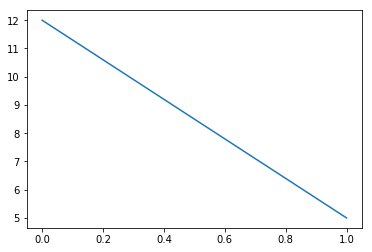

In [29]:
import matplotlib.pyplot as plt

testa = []
testa.append(12)
testa.append(5)
plt.plot(testa)
plt.show()